In [1]:
import h5py, os, math
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import cmasher as cmr

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
from tqdm import tqdm

In [2]:
nside = 512
np.random.seed(11)
Cl = np.arange(1, 1001)**-3.
example_map = hp.synfast(cls=Cl, nside=nside)

In [3]:
import numpy as np
import healpy as hp
import math


def _deinterleave(local, k):
    """Return (x, y) from Morton (interleaved) local index for k bits per coord."""
    x = 0
    y = 0
    for i in range(k):
        x |= ((local >> (2 * i)) & 1) << i
        y |= ((local >> (2 * i + 1)) & 1) << i
    return x, y


def superpixel_patch(
    hpmap, nside_high, nside_super, ipix_super="equator", nest=True, origin="lower", return_ipix=False
):
    """
    Extract the high-resolution pixels inside one low-resolution (super-)pixel
    and return them as a square 2D array suitable for plt.imshow.

    Parameters
    ----------
    hpmap : 1D array
        HEALPix map at nside_high (length must be 12*nside_high**2).
    nside_high : int
        High-resolution nside (e.g. 512).
    nside_super : int
        Lower-resolution nside of the super-pixel (e.g. 2).
    ipix_super : int or str
        Index of the super-pixel (0 <= ipix_super < 12 * nside_super**2),
        OR one of the special strings:
            - "equator" → choose the superpixel centered closest to lat=0°, lon=0°.
    nest : bool, optional
        True if `hpmap` is in NESTED ordering. If False, the function will
        internally convert it using healpy (ring -> nest).
    origin : {'lower','upper'}, optional
        Pixel-origin convention to return (matches plt.imshow origin).
    return_ipix : bool, optional
        If True, also return a grid of high-res pixel indices.

    Returns
    -------
    patch : 2D ndarray
        Array of shape (factor, factor) with the pixel values.
    ipix_grid : 2D ndarray (optional)
        Array of same shape with the corresponding high-res NESTED pixel indices
        (only if return_ipix=True).
    """
    # sanity checks
    if nside_high % nside_super != 0:
        raise ValueError("nside_high must be an integer multiple of nside_super")
    factor = nside_high // nside_super
    if factor & (factor - 1):
        raise ValueError("ratio (nside_high/nside_super) must be a power of two")
    if origin not in ("lower", "upper"):
        raise ValueError("origin must be 'lower' or 'upper'")

    # convert map to NESTED if user supplied ring ordering
    if not nest:
        hpmap = hp.reorder(hpmap, r2n=True)

    npix_high = hp.nside2npix(nside_high)
    if hpmap.size != npix_high:
        raise ValueError(f"hpmap length ({hpmap.size}) does not match nside_high ({npix_high})")

    n_superpix = hp.nside2npix(nside_super)

    # choose equatorial superpixel automatically
    if isinstance(ipix_super, str):
        key = ipix_super.lower()
        if key == "equator":
            # Find the superpixel whose center is closest to lat=0°, lon=0°
            theta, phi = hp.pix2ang(nside_super, np.arange(n_superpix), nest=True)
            lat = 90.0 - np.degrees(theta)
            lon = np.degrees(phi)
            # find pixel closest to lat=0°, lon=0° (wrap longitude to [-180,180])
            lon = ((lon + 180) % 360) - 180
            dist2 = lat**2 + lon**2
            ipix_super = int(np.argmin(dist2))
        else:
            raise ValueError(f"Unknown string for ipix_super: {ipix_super}")

    if not (0 <= ipix_super < n_superpix):
        raise ValueError(f"ipix_super must be in [0, {n_superpix-1}]")

    # compute deinterleaving parameters
    k = int(round(math.log2(factor)))
    start = ipix_super * (factor * factor)

    patch = np.empty((factor, factor), dtype=hpmap.dtype)
    ipix_grid = np.empty((factor, factor), dtype=np.int64)

    for local in range(factor * factor):
        x, y = _deinterleave(local, k)
        ip = start + local
        patch[y, x] = hpmap[ip]
        ipix_grid[y, x] = ip

    if origin == "upper":
        patch = np.flipud(patch)
        ipix_grid = np.flipud(ipix_grid)

    if return_ipix:
        return patch, ipix_grid
    return patch

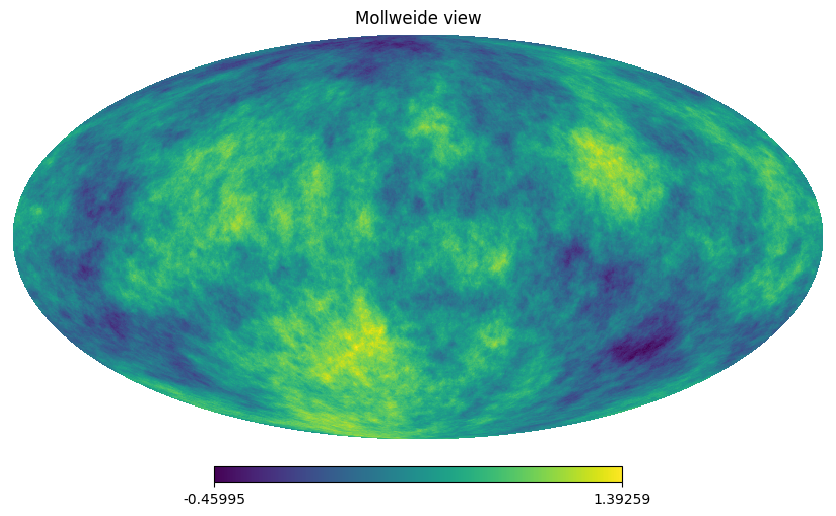

In [4]:
hp.mollview(example_map)

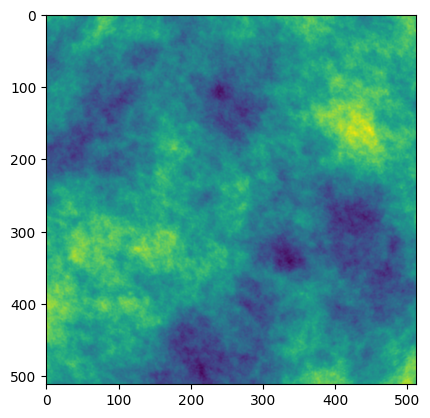

In [11]:
example_patch = superpixel_patch(example_map, nside, 1, nest=False)
plt.imshow(example_patch)

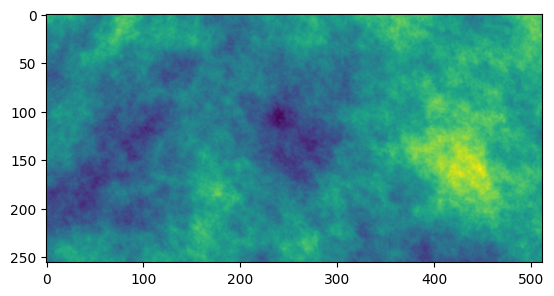

In [13]:
example_patch = superpixel_patch(example_map, nside, 1, nest=False)
plt.imshow(example_patch[:(example_patch.shape[0]//2),:])